# Analysis of in-situ shocks

Today we analyze Solar Orbiter in-situ observations of interplanetary shocks.

**Candidate events:**
- Event 1: 11 Oct 2021
- Event 2: 30 Oct 2021
- Event 3: 3 Nov 2021
- Event 4: 27 Nov 2021

We use magnetic field data (MAG instrument) and ground plasma moment data (SWA-PAS). The data can be easily downloaded using the data loaders.

**Basics:**
1. Pick one date.

2. Load data and plot an overview timeseries plot of that date:
    - Magnetic field in RTN coordinates
    - Velocity in RTN coordinates
    - Proton density
    - Proton temperature
    
    Find the shock crossing. Plot a line at the estimated shock crossing time.
    
3. Make a new plot where you have zoomed in at the shock. Find the exact shock time and select representative upstream and downstream windows for shock analysis.
4. Average the magnetic field and plasma data in the upstream and downstream windows. Use these upstream and downstream conditions to calculate:
    - Shock normal using the mixed-mode method
    - Shock speed using the mass-flux algorithm
    - Shock obliquity $\theta_{Bn}$
    - Alfvén Mach number of the shock
    
**SerPyShock:**

SerPyShock working example (systematic approach to vary the upstream and downstream window lengths and estimate the uncertainty of the derived shock parameters).

**Extra:**

Calculate the ion inertial length $d_\mathrm{i}$ in the upstream and downstream windows. How long does it take for the plasma to propagate one ion inertial length? How about 50 Earth radii (comparable to the size of the Earth's magnetosphere)?
    $$d_\mathrm{i}=c/\omega_\mathrm{pi}$$
    $$\omega_\mathrm{pi}=\sqrt{\frac{n_\mathrm{i}q_\mathrm{i}^2}{\epsilon_0 m_\mathrm{i}}}$$

# Basics

In [1]:
from matplotlib import pyplot as plt
from solo_mag_loader import mag_load
from solo_epd_loader import epd_load
from solo_swa_loader import swa_load_grnd_mom
import datetime as dt
import numpy as np
import pandas as pd
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator)
import matplotlib.dates as mdates

In [2]:
path = 'data/'  # Directory for the downloaded data in this project
plt.rcParams.update({'font.size': 12})  # increase font size for matplotlib

In [3]:
startdate = dt.date(2021, 11, 2)
enddate = dt.date(2021, 11, 4)

## Download MAG data

In [4]:
df_mag_1min = mag_load(startdate, enddate, level='l2', data_type='normal-1-minute', frame='rtn', path=path)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_l2_mag-rtn-normal-1-minute_20211102_v01.cdf:   0%|          | 0.00/60.6k [00:00<?, ?B/s]

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_l2_mag-rtn-normal-1-minute_20211103_v01.cdf:   0%|          | 0.00/61.0k [00:00<?, ?B/s]

## Download SWA ground moments data

In [5]:
df_swa = swa_load_grnd_mom(startdate, enddate, path=path)

Files Downloaded:   0%|          | 0/3 [00:00<?, ?file/s]

solo_L2_swa-pas-grnd-mom_20211102_V03.cdf:   0%|          | 0.00/3.34M [00:00<?, ?B/s]

solo_L2_swa-pas-grnd-mom_20211104_V03.cdf:   0%|          | 0.00/3.34M [00:00<?, ?B/s]

solo_L2_swa-pas-grnd-mom_20211103_V03.cdf:   0%|          | 0.00/3.34M [00:00<?, ?B/s]

In [6]:
#Calculate vector magnitudes
df_mag_1min["B"] = np.linalg.norm(df_mag_1min[["B_RTN_0","B_RTN_1","B_RTN_2"]],axis=1)
df_swa["V"] = np.linalg.norm(df_swa[["V_RTN_0","V_RTN_1","V_RTN_2"]],axis=1)

## Overview timeseries plot

(18933.0, 18935.0)

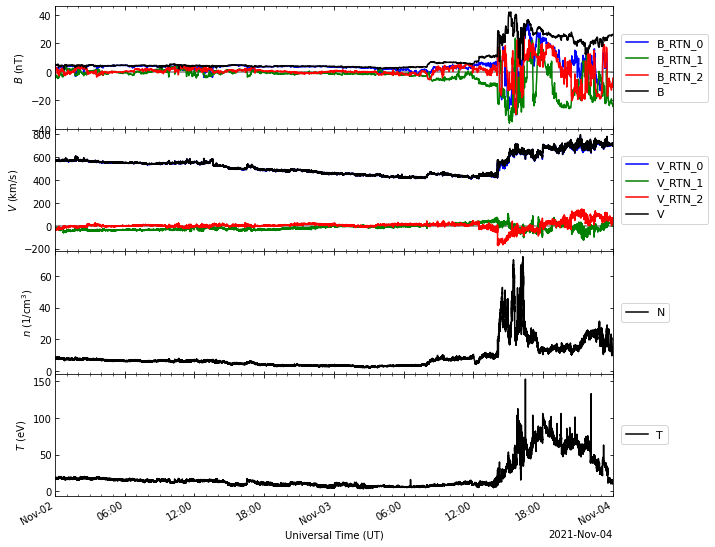

In [7]:
fig, axs = plt.subplots(4, 1,figsize=[10,10],sharex=True)
fig.subplots_adjust(hspace=0)

panel = 0
axs[panel].axhline(y=0, ls='-', color="grey")
df_mag_1min[["B_RTN_0","B_RTN_1","B_RTN_2","B"]].plot(ax=axs[panel],color=["blue","green","red","black"])
axs[panel].set_ylabel("$B$ (nT)")
#axs[panel].set_ylim(-20,20)

panel += 1
axs[panel].axhline(y=0, ls='-', color="grey")
df_swa[["V_RTN_0","V_RTN_1","V_RTN_2","V"]].plot(ax=axs[panel],color=["blue","green","red","black"])
axs[panel].set_ylabel("$V$ (km/s)")

panel += 1
df_swa["N"].plot(ax=axs[panel],color="black")
axs[panel].set_ylabel("$n$ (1/cm$^3$)")

panel += 1
df_swa["T"].plot(ax=axs[panel],color="black")
axs[panel].set_ylabel("$T$ (eV)")

axs[-1].set_xlabel("Universal Time (UT)")
locator = mdates.AutoDateLocator()
fmt_min = mdates.MinuteLocator(interval=60)
for ax in axs:
    ax.legend(loc="center left",bbox_to_anchor=[1.005,0.5],fontsize=11)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.tick_params(axis='x', which ='both', direction='in', top=True)
    ax.tick_params(axis='y', which ='both', direction='in', right=True)
    ax.xaxis.set_minor_locator(fmt_min)
    #PLOT YOUR ESTIMATED SHOCK TIME
    #ax.axvline(x=pd.to_datetime('2021-11-01T00:00:00'), ls='--', color="darkorange",lw=2)
    
axs[-1].set_xlim([startdate,enddate])
#axs[-1].set_xlim(pd.to_datetime(['2021-11-24T00:00:00','2021-11-26T00:00:00']))

## Plot a timeseries figure zooming in to the surroundings of the shock

In [8]:
#Set zoomed-in plotting window
start_time = pd.to_datetime('2021-11-03 13:50:00')
end_time = pd.to_datetime('2021-11-03 14:20:00')

### Download higher-resolution MAG data and non-resampled EPT data for the zoomed-in interval

In [9]:
#Download magnetic field data for the zoomed-in interval
df_mag_normal = mag_load(start_time, end_time, level='l2', data_type='normal', frame='rtn', path="./mag")
df_mag_normal["B"] = np.linalg.norm(df_mag_normal[["B_RTN_0","B_RTN_1","B_RTN_2"]],axis=1)

Files Downloaded:   0%|          | 0/1 [00:00<?, ?file/s]

solo_l2_mag-rtn-normal_20211103_v01.cdf:   0%|          | 0.00/13.0M [00:00<?, ?B/s]

In [10]:
df_swa_zoomed = df_swa.loc[(df_swa.index >= start_time) & (df_swa.index <= end_time)]

In [11]:
#Set shock time and windows for upstream and downstream
shock_time = pd.to_datetime('2021-11-03 14:04:20')

up_start = pd.to_datetime('2021-11-03 13:59:00')
up_end = pd.to_datetime('2021-11-03 14:03:00')
down_start = pd.to_datetime('2021-11-03 14:05:40')
down_end = pd.to_datetime('2021-11-03 14:07:40')

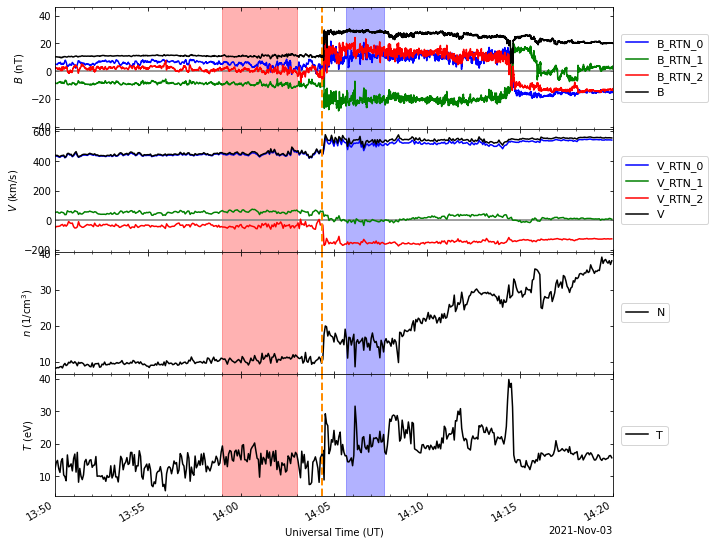

In [12]:
fig, axs = plt.subplots(4, 1,figsize=[10,10],sharex=True)
fig.subplots_adjust(hspace=0)

panel = 0
axs[panel].axhline(y=0, ls='-', color="grey")
df_mag_normal[["B_RTN_0","B_RTN_1","B_RTN_2","B"]].plot(ax=axs[panel],color=["blue","green","red","black"])
axs[panel].set_ylabel("$B$ (nT)")
#axs[panel].set_ylim([-10,20])

panel += 1
axs[panel].axhline(y=0, ls='-', color="grey")
df_swa_zoomed[["V_RTN_0","V_RTN_1","V_RTN_2","V"]].plot(ax=axs[panel],color=["blue","green","red","black"])
axs[panel].set_ylabel("$V$ (km/s)")
#axs[panel].set_ylim([-50,450])

panel += 1
df_swa_zoomed["N"].plot(ax=axs[panel],color="black")
axs[panel].set_ylabel("$n$ (1/cm$^3$)")

panel += 1
df_swa_zoomed["T"].plot(ax=axs[panel],color="black")
axs[panel].set_ylabel("$T$ (eV)")
#axs[panel].set_ylim([0,15])

axs[-1].set_xlabel("Universal Time (UT)")
locator = mdates.AutoDateLocator()
fmt_min = mdates.MinuteLocator(interval=1)
for ax in axs:
    ax.legend(loc="center left",bbox_to_anchor=[1.005,0.5],fontsize=11)
    ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))
    ax.tick_params(axis='x', which ='both', direction='in', top=True)
    ax.tick_params(axis='y', which ='both', direction='in', right=True)
    ax.xaxis.set_minor_locator(fmt_min)
    
axs[-1].set_xlim([start_time,end_time])

#PLOT SHOCK TIME & UPSTREAM AND DOWNSTREAM WINDOWS
for ax in axs:
    ax.axvline(x=shock_time, ls='--', color="darkorange",lw=2)
    ax.axvspan(up_start, up_end, alpha=0.3, color="red")
    ax.axvspan(down_start,down_end, alpha=0.3, color="blue")
    
#fig.savefig("example_shock.png",dpi=300,format='png', bbox_inches='tight',facecolor="white")

## Shock analysis functions (for the theory, please check Heli Hietala's slides in the folder)

In [13]:
def mixed_mode_normals(B_up_vec, B_down_vec, V_up_vec, V_down_vec):
    """
    Calculates the three mixed-mode shock normal vectors using
    averaged B and V vectors in the upstream and downstream
    windows.
    """
    dif_B = B_down_vec - B_up_vec
    dif_V = V_down_vec - V_up_vec
    normal1 = np.cross(np.cross(B_up_vec,dif_V),dif_B)
    normal1 = normal1 / np.linalg.norm(normal1)
    normal2 = np.cross(np.cross(B_down_vec,dif_V),dif_B)
    normal2 = normal2 / np.linalg.norm(normal2)
    normal3 = np.cross(np.cross(dif_B,dif_V),dif_B)
    normal3 = normal3 / np.linalg.norm(normal3)
    return np.array([normal1,normal2,normal3])

In [14]:
def mass_flux_algorithm(n_up, n_down, V_up_vec, V_down_vec,shock_normal):
    """
    Calculates the shock speed in spacecraft frame using the conservation
    of mass flux across the shock.
    """
    flux_down = n_down*V_down_vec
    flux_up = n_up*V_up_vec
    flux_dif = flux_down-flux_up
    n_dif = n_down - n_up
    shock_speed = np.dot(flux_dif,shock_normal)/n_dif
    return shock_speed

In [15]:
def shock_obliquity(B_up_vec,shock_normal):
    """
    Calculates the theta_Bn [0 deg,90 deg] angle between
    the shock normal and the upstream magnetic field.
    """
    dott = np.dot(B_up_vec,shock_normal)
    B_norm = np.linalg.norm(B_up_vec)
    n_norm = np.linalg.norm(shock_normal)
    theta_bn = np.degrees(np.arccos(dott/(B_norm*n_norm)))
    if theta_bn > 90:
        theta_bn = 180 - theta_bn
    return theta_bn

In [16]:
def alfven_speed(B_vec,n):
    """
    Calculates the Alfven speed assuming protons only.
    Takes B vector in (nT) and n in (1/cc).
    Returns Alfven speed in (km/s).
    """
    B = np.linalg.norm(B_vec)*10**(-9) #teslas
    n = n*10**(6) #1/m^3
    m_p = 1.6726219*10**(-27) #proton mass (kg)
    mu_0 = 1.25663706*10**(-6) #vacuum permeability (m*kg/(s*A)**2)
    v_a = B/np.sqrt(mu_0*m_p*n)
    return v_a/1000

In [17]:
#Calculate averages of B and V vectors and density in the upstream and downstream windows
B_up_vec = df_mag_normal.iloc[(df_mag_normal.index>=up_start) & (df_mag_normal.index<=up_end)][["B_RTN_0","B_RTN_1","B_RTN_2"]]
B_up_vec = B_up_vec.mean(axis=0,skipna=True).values
B_down_vec = df_mag_normal.iloc[(df_mag_normal.index>=down_start) & (df_mag_normal.index<=down_end)][["B_RTN_0","B_RTN_1","B_RTN_2"]]
B_down_vec = B_down_vec.mean(axis=0,skipna=True).values
V_up_vec = df_swa_zoomed.iloc[(df_swa_zoomed.index>=up_start) & (df_swa_zoomed.index<=up_end)][["V_RTN_0","V_RTN_1","V_RTN_2"]]
V_up_vec = V_up_vec.mean(axis=0,skipna=True).values
V_down_vec = df_swa_zoomed.iloc[(df_swa_zoomed.index>=down_start) & (df_swa_zoomed.index<=down_end)][["V_RTN_0","V_RTN_1","V_RTN_2"]]
V_down_vec = V_down_vec.mean(axis=0,skipna=True).values
n_up = df_swa_zoomed.iloc[(df_swa_zoomed.index>=up_start) & (df_swa_zoomed.index<=up_end)]["N"]
n_up = n_up.mean(skipna=True)
n_down = df_swa_zoomed.iloc[(df_swa_zoomed.index>=down_start) & (df_swa_zoomed.index<=down_end)]["N"]
n_down = n_down.mean(skipna=True)

In [18]:
#The mixed-mode normals
normals = mixed_mode_normals(B_up_vec, B_down_vec, V_up_vec, V_down_vec)
n1 = normals[0]
n2 = normals[1]
n3 = normals[2]
print('Mixed-mode normals:')
print(normals)
#Calculate the average of the vectors (check the signs!)
n_avg = (n1 + n2 + n3)/3
print('Average mixed-mode normal:')
print(n_avg)

Mixed-mode normals:
[[ 0.46940416 -0.5918101  -0.6553018 ]
 [ 0.4953442  -0.5723927  -0.65345293]
 [ 0.5067478  -0.56353605 -0.65240616]]
Average mixed-mode normal:
[ 0.4904987  -0.57591295 -0.6537203 ]


In [19]:
#Estimating shock speed along the normal vector
shock_normal = n_avg #Check normal sign!
print('Shock normal:')
print(shock_normal)
shock_speed = mass_flux_algorithm(n_up, n_down, V_up_vec, V_down_vec,shock_normal)
print('Shock speed:')
print(shock_speed)

Shock normal:
[ 0.4904987  -0.57591295 -0.6537203 ]
Shock speed:
694.8156


In [20]:
#Estimating shock obliquity
theta_bn = shock_obliquity(B_up_vec,shock_normal)
print('Shock obliquity:')
print(theta_bn)

Shock obliquity:
46.37329


In [21]:
shock_velocity = shock_normal*shock_speed
print('Shock velocity:')
print(shock_velocity)

Shock velocity:
[ 340.80615 -400.15332 -454.2151 ]


In [22]:
#Velocities in the shock frame
V_up_vec_shockframe =  V_up_vec - shock_velocity
V_down_vec_shockframe =  V_down_vec - shock_velocity
#Plasma speeds along shock normal in the shock frame
Vn_up_shockframe = np.dot(V_up_vec_shockframe,shock_normal)
Vn_down_shockframe = np.dot(V_down_vec_shockframe,shock_normal)

In [23]:
#Calculate upstream Alfven Mach number (in the shock frame)
VA_up = alfven_speed(B_up_vec,n_up)
MA = np.abs(Vn_up_shockframe)/VA_up
print("Alfvén Mach number:")
print(MA)

Alfvén Mach number:
6.797135772752014


# SerPyShock example

Compute shock obliquity with Solar Orbiter Data. Use SerPyShock to estimate the uncertainty related to upstream and downstream window selections.

In [24]:
from SerPyShock import SerPyShock

## Choose the largest and smallest upstream & downstream windows.

In [25]:
#Select the largest upstream window (using the ipshocks.fi standard)
start_time_up  = shock_time  - dt.timedelta(minutes = 9)
end_time_up = shock_time  - dt.timedelta(minutes = 1)
#Select the largest downstream window (using the ipshocks.fi standard)
start_time_down  = shock_time  + dt.timedelta(minutes = 2)
end_time_down = shock_time  + dt.timedelta(minutes = 10)

In [26]:
#Select minimum and maximum durations of the upstream and downstream windows
#for the systematic analysis
min_dur_up = dt.timedelta(minutes=2)
max_dur_up = end_time_up - start_time_up
min_dur_down =  dt.timedelta(minutes=2)
max_dur_down = end_time_down - start_time_down
#Select the cadence by which the window lengths are increased
cadence =  dt.timedelta(seconds=20)

## Run SerPyShock

In [27]:
#Prepare the input parameters for SerPyShock
B = df_mag_normal[["B_RTN_0","B_RTN_1","B_RTN_2"]].values
B_times = df_mag_normal.index
V = df_swa_zoomed[["V_RTN_0","V_RTN_1","V_RTN_2"]].values
n = df_swa_zoomed["N"].values
Tp = df_swa_zoomed["T"].values
mom_times = df_swa_zoomed.index
coord = "RTN"

In [28]:
#Run SerPyShock systematic calculations
n, tbn, rB, ex = SerPyShock.MX_stats(B_times, B, mom_times, V, shock_time, end_time_up, start_time_down, min_dur_up, max_dur_up, min_dur_down, max_dur_down, cadence, coord)

Upstream windows = 0 / 18
Upstream windows = 1 / 18
Upstream windows = 2 / 18
Upstream windows = 3 / 18
Upstream windows = 4 / 18
Upstream windows = 5 / 18
Upstream windows = 6 / 18
Upstream windows = 7 / 18
Upstream windows = 8 / 18
Upstream windows = 9 / 18
Upstream windows = 10 / 18
Upstream windows = 11 / 18
Upstream windows = 12 / 18
Upstream windows = 13 / 18
Upstream windows = 14 / 18
Upstream windows = 15 / 18
Upstream windows = 16 / 18
Upstream windows = 17 / 18


## Plot the results

### Plot the probability distribution for $\theta_{Bn}$

(0.0, 90.0)

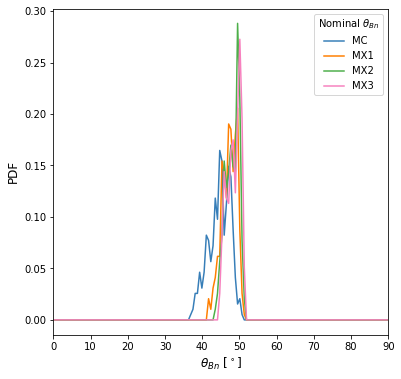

In [29]:
#Plot theta_bn diagnostics
fig = plt.figure(figsize = (6,6))
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
nbns = 150
hist1,bin_edges = np.histogram(tbn.MC, bins = nbns, range=(0,90), density=True)
hist2,bin_edges = np.histogram(tbn.MX1, bins = nbns, range=(0,90), density=True)
hist3,bin_edges = np.histogram(tbn.MX2, bins = nbns, range=(0,90), density=True)
hist4,bin_edges = np.histogram(tbn.MX3, bins = nbns, range=(0,90), density=True)

bin_centers = bin_edges[0:-1] + (bin_edges[1:]-bin_edges[0:-1])/2

plt.plot(bin_centers,hist1, color = CB[0], label = 'MC')
plt.plot(bin_centers,hist2, color = CB[1], label = 'MX1')
plt.plot(bin_centers,hist3, color = CB[2], label = 'MX2')
plt.plot(bin_centers,hist4, color = CB[3], label = 'MX3')

plt.xlabel(r'$\theta_{Bn}$ $[^\circ]$',fontsize=12)
plt.ylabel(r'PDF',fontsize=12)
plt.legend(fontsize=10,title = r'Nominal $\theta_{Bn}$')
plt.xlim(0,90)

### Plot the timeseries and the probability distribution for $\theta_{Bn}$ together

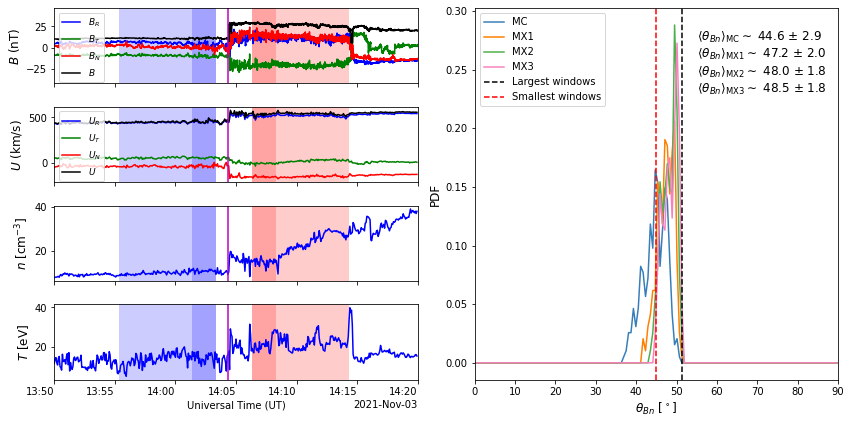

In [30]:
plt.rcParams.update({'font.size': 10})

#Determine the limits of the upstream and downstream windows, smallest and largest
sldu = int(np.floor((max_dur_up-min_dur_up)/cadence)) 
sldd = int(np.floor((max_dur_down-min_dur_down)/cadence))
stut_min = end_time_up - min_dur_up - 0*cadence
stut_max = end_time_up - min_dur_up - sldu*cadence
endt_min = start_time_down + min_dur_down + 0*cadence
endt_max = start_time_down + min_dur_down + sldd*cadence

fsax = 12 #fontsize ax 
fig = plt.figure(figsize = (12,6))
gs = fig.add_gridspec(4,2)

ax1 = fig.add_subplot(gs[0, 0])
df_mag_normal[["B_RTN_0","B_RTN_1","B_RTN_2","B"]].plot(ax=ax1,color=["blue","green","red","black"])
ax1.set_ylabel("$B$ (nT)",fontsize=fsax)
ax1.legend(loc='upper left', fontsize=9,labels=["$B_R$","$B_T$","$B_N$","$B$"])

ax2 = fig.add_subplot(gs[1, 0])
df_swa_zoomed[["V_RTN_0","V_RTN_1","V_RTN_2","V"]].plot(ax=ax2,color=["blue","green","red","black"])
ax2.set_ylabel("$U$ (km/s)", fontsize=fsax)
ax2.legend(loc='upper left', fontsize=9,labels=["$U_R$","$U_T$","$U_N$","$U$"])

ax3 = fig.add_subplot(gs[2, 0])
df_swa_zoomed["N"].plot(ax=ax3,color="b")
ax3.set_ylabel('$n$ [cm$^{-3}$]',fontsize=fsax)

ax4 = fig.add_subplot(gs[3, 0])
df_swa_zoomed["T"].plot(ax=ax4,color="b",rot=0)
ax4.set_ylabel('$T$ [eV]',fontsize=fsax)
ax4.set_xlabel("Universal Time (UT)")
locator = mdates.AutoDateLocator()
ax4.xaxis.set_major_formatter(mdates.ConciseDateFormatter(locator))

for ax in [ax1,ax2,ax3,ax4]:
    ax.axvline(x=shock_time,color='m')
    ax.axvspan(stut_min,end_time_up, facecolor = 'b', alpha = 0.2)
    ax.axvspan(stut_max,end_time_up, facecolor = 'b', alpha = 0.2)
    ax.axvspan(start_time_down,endt_min, facecolor = 'r', alpha = 0.2)
    ax.axvspan(start_time_down,endt_max, facecolor = 'r', alpha = 0.2)
    ax.set_xlim(start_time,end_time)
    if ax!=ax4:
        ax.set_xticklabels('')
        ax.set_xlabel('')

ax5 = fig.add_subplot(gs[0:5, 1])
CB = ['#377eb8', '#ff7f00', '#4daf4a',
                  '#f781bf', '#a65628', '#984ea3',
                  '#999999', '#e41a1c', '#dede00']
ax5.plot(bin_centers,hist1, color = CB[0], label = 'MC')
ax5.plot(bin_centers,hist2, color = CB[1], label = 'MX1')
ax5.plot(bin_centers,hist3, color = CB[2], label = 'MX2')
ax5.plot(bin_centers,hist4, color = CB[3], label = 'MX3')
ax5.axvline(x=ex.tbn_luld,linestyle = '--',color='black', label = 'Largest windows')
ax5.axvline(x=ex.tbn_susd,linestyle = '--',color='red',   label = 'Smallest windows')
ax5.set_xlabel(r'$\theta_{Bn}$ $[^\circ]$',fontsize=fsax)
ax5.set_ylabel(r'PDF',fontsize=fsax)
ax5.legend(fontsize=10, loc='upper left')

values = [tbn.MC,tbn.MX1,tbn.MX2,tbn.MX3]
labels = ["MC","MX1","MX2","MX3"]
i = 0
for value,label in zip(values,labels):
    avg = np.mean(value)
    std = np.std(value)
    st = '$\langle \\theta_{Bn} \\rangle_{\mathrm{%s}} \sim $ %0.1f $\pm $ %0.1f' %(label,avg,std)
    plt.text(55,0.275-i*0.015,st,fontsize=12)
    i += 1

ax5.set_xlim(0,90)

plt.tight_layout()

# Extra

Calculate the ion inertial length $d_\mathrm{i}$ in the upstream and downstream windows. How long does it take for the plasma to propagate one ion inertial length? How about 50 Earth radii (comparable to the size of the Earth's magnetosphere)?
    $$d_\mathrm{i}=c/\omega_\mathrm{pi}$$
    $$\omega_\mathrm{pi}=\sqrt{\frac{n_\mathrm{i}q_\mathrm{i}^2}{\epsilon_0 m_\mathrm{i}}}$$

In [31]:
def ion_inertial_length(n):
    """
    Calculates ion inertial length (km) assuming protons only.
    Takes in number density (1/cc).
    """
    c = 2.998*10**8 #speed of light (m/s)
    q = 1.602*10**(-19) #elementary charge (C)
    m_p = 1.673*10**(-27) #proton mass (kg)
    n = n*10**6 #1/m^3
    eps_0 = 8.854*10**(-12) #vacuum permittivity (F/m)
    omega_pi = np.sqrt(n*q**2/(eps_0*m_p))
    d_i = c/omega_pi
    return d_i/1000

In [32]:
#Calculate ion inertial lengths upstream and downstream
d_i_up = ion_inertial_length(n_up)
print("Ion inertial length (upstream):")
print("%.2f km" %d_i_up)
d_i_down = ion_inertial_length(n_down)
print("Ion inertial length (downstream):")
print("%.2f km" %d_i_down)

V_up = np.linalg.norm(V_up_vec)
V_down = np.linalg.norm(V_down_vec)

print("Ion inertial length (upstream) in duration:")
print("%.2f s" %(d_i_up/V_up))

print("Ion inertial length (downstream) in duration:")
print("%.2f s" %(d_i_down/V_down))

print("1000 ion inertial lengths (upstream) in duration:")
print("%.2f min" %((1000*d_i_up/V_up)/60))

print("1000 ion inertial lengths (downstream) in duration:")
print("%.2f min" %((1000*d_i_down/V_down)/60))

Ion inertial length (upstream):
69.71 km
Ion inertial length (downstream):
58.64 km
Ion inertial length (upstream) in duration:
0.15 s
Ion inertial length (downstream) in duration:
0.11 s
1000 ion inertial lengths (upstream) in duration:
2.56 min
1000 ion inertial lengths (downstream) in duration:
1.84 min
